# A demo walkthrough of downloading and building taxonomies for two iHMP metagenomes

The below demo does the following:
* uses an NCPI manifest file exported from [the CFDE data portal](https://app.nih-cfde.org/) to download two iHMP metagenomes via [GA4GH DRS](https://ga4gh.github.io/data-repository-service-schemas/preview/release/drs-1.0.0/docs/).
* sketches the metagenomes into k-mer FracMinHash sketches using the [sourmash software] (https://sourmash.readthedocs.io/en/latest/).
* searches the metagenomes against [the Genome Taxonomy Database](https://gtdb.ecogenomic.org/) to find [a minimum metagenome cover](https://www.biorxiv.org/content/10.1101/2022.01.11.475838v2).
* presents a taxonomic view of the metagenomes using [metacoder](https://github.com/grunwaldlab/metacoder).

🎉

It can be run on an Amazon cloud instance easily; see [the host repo](https://github.com/ctb/2022-may-cfde-demo) for installation instructions.

## Set up paths

In [1]:
!echo $PATH

/opt/tljh/user/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin


In [2]:
import os
print(os.environ['PATH'])
os.environ['PATH'] = '/home/jupyter-cfde/miniforge3/bin:' + os.environ['PATH']

/opt/tljh/user/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin


In [3]:
os.environ['PATH']

'/home/jupyter-cfde/miniforge3/bin:/opt/tljh/user/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin'

## Do a dry run download - everything green?

I've built a little [snakemake](http://snakemake.readthedocs.io/) workflow to download the contents of the manifest.

Let's see if it has any complaints:

In [4]:
!snakemake -s download.drs -j 1 --config manifest=example-manifest.csv -n

Getting mZBm6TYnDQoS from https://drs.hmpdacc.org
Getting DGLpSDR29kHp from https://drs.hmpdacc.org
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).


## Fire for effect: run the download

If everything above is green, then we can actually run the download:

In [5]:
!snakemake -s download.drs -j 2 --config manifest=example-manifest.csv

Getting mZBm6TYnDQoS from https://drs.hmpdacc.org
Getting DGLpSDR29kHp from https://drs.hmpdacc.org
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).
Complete log: .snakemake/log/2022-05-10T144832.016992.snakemake.log


Everything green?

If so, victory! 🎉

## Look at downloaded files

In [6]:
ls

DGLpSDR29kHp/            demo-walkthrough.ipynb
INSTALL.md               download.drs
LICENSE                  drs_download_report.txt
README.md                example-manifest.csv
Rplots.pdf               gtdb-rs207.genomic-reps.dna.k31.zip
SRR5935743_1.fastq.sig   gtdb-rs207.taxonomy.csv.gz
SRR5950647_1.fastq.sig   mZBm6TYnDQoS/
SRR5950647_1.gather.csv  sourmash_gather_to_metacoder_plot.R*
SRR5950647_1.tax.png


In [7]:
ls DGLpSDR29kHp/ mZBm6TYnDQoS/

DGLpSDR29kHp/:
SRR5950647_1.fastq

mZBm6TYnDQoS/:
SRR5935743_1.fastq


## Sketch them with sourmash

Next, we will construct k-mer sketches with [sourmash](http://sourmash.readthedocs.io/), some software my group maintains.

In [8]:
!sourmash sketch dna DGLpSDR29kHp/*.fastq mZBm6TYnDQoS/*.fastq


== This is sourmash version 4.3.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

computing signatures for files: DGLpSDR29kHp/SRR5950647_1.fastq, mZBm6TYnDQoS/SRR5935743_1.fastq
Computing a total of 1 signature(s) for each input.
skipping DGLpSDR29kHp/SRR5950647_1.fastq - already done
skipping mZBm6TYnDQoS/SRR5935743_1.fastq - already done


## Download a sourmash database and taxonomy file

We'll use the [sourmash prepared files](https://sourmash.readthedocs.io/en/latest/databases.html) for [the Genome Taxonomy Database](https://gtdb.ecogenomic.org/) genomic representatives.

This is a database containing ~60,000 genomes. (The full ~300k genome database is available; it just takes longer!)

In [9]:
!curl -JLO https://osf.io/v3zmg/download
!curl -JLO https://osf.io/3a6gn/download

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   483  100   483    0     0    139      0  0:00:03  0:00:03 --:--:--   139
  0     0    0     0    0     0      0      0 --:--:--  0:00:18 --:--:--     0Warning: Failed to open the file gtdb-rs207.taxonomy.csv.gz: File exists
  0     0    0     0    0     0      0      0 --:--:--  0:00:19 --:--:--     0
curl: (23) Failed writing header
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   501  100   501    0     0    194      0  0:00:02  0:00:02 --:--:--   194
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0Warning: Failed to open the file gtdb-rs207.genomic-reps.dna.k31.zip: File 
  0     0    0     0    0     0      0      0 --:--:--  0:00:05 --:--:--     0
curl: (23) Failed writing head

In [10]:
ls gtdb*

gtdb-rs207.genomic-reps.dna.k31.zip  gtdb-rs207.taxonomy.csv.gz


## Run sourmash to search the metagenome against the taxonomy

We will use [sourmash gather](https://sourmash.readthedocs.io/en/latest/command-line.html#sourmash-gather-find-metagenome-members) to build 
a [minimum metagenome cover](https://www.biorxiv.org/content/10.1101/2022.01.11.475838v2) for the first metagenome.
                              

First, let's test everything by doing a search against just the Prevotella members of the database.

This is a quick search (should take ~15 seconds) just to kick the tires:

In [11]:
!sourmash gather SRR5950647_1.fastq.sig gtdb-rs207.genomic-reps.dna.k31.zip --include prevotella


== This is sourmash version 4.3.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

select query k=31 automatically.
loaded query: DGLpSDR29kHp/SRR5950647_1.fast... (k=31, DNA)
loaded 1 databases.                                                            

Starting prefetch sweep across databases.
Found 4 signatures via prefetch; now doing gather.

overlap     p_query p_match
---------   ------- -------
115.0 kbp      2.1%    3.1%    GCF_015074785.1 Prevotella copri stra...
found less than 50.0 kbp in common. => exiting

found 1 matches total;
the recovered matches hit 2.1% of the query (unweighted)



## If that works, let's do a search against the full database

This will take ~5 minutes.

In [ ]:
!sourmash gather SRR5950647_1.fastq.sig gtdb-rs207.genomic-reps.dna.k31.zip -o SRR5950647_1.gather.csv

## Now, build a taxonomic view based on the contents

In [12]:
!./sourmash_gather_to_metacoder_plot.R SRR5950647_1.gather.csv SRR5950647_1.tax.png


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

This is metacoder verison 0.3.5 (stable)
Rows: 317542 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): ident, superkingdom, phylum, class, order, family, genus, species

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Summing per-taxon counts from 1 columns for 15 taxa


## View taxonomy

And now you can see the relatively uninteresting taxonomy of these very small samples 😂.

(For Thursday's sessions, we can do some bigger samples!)

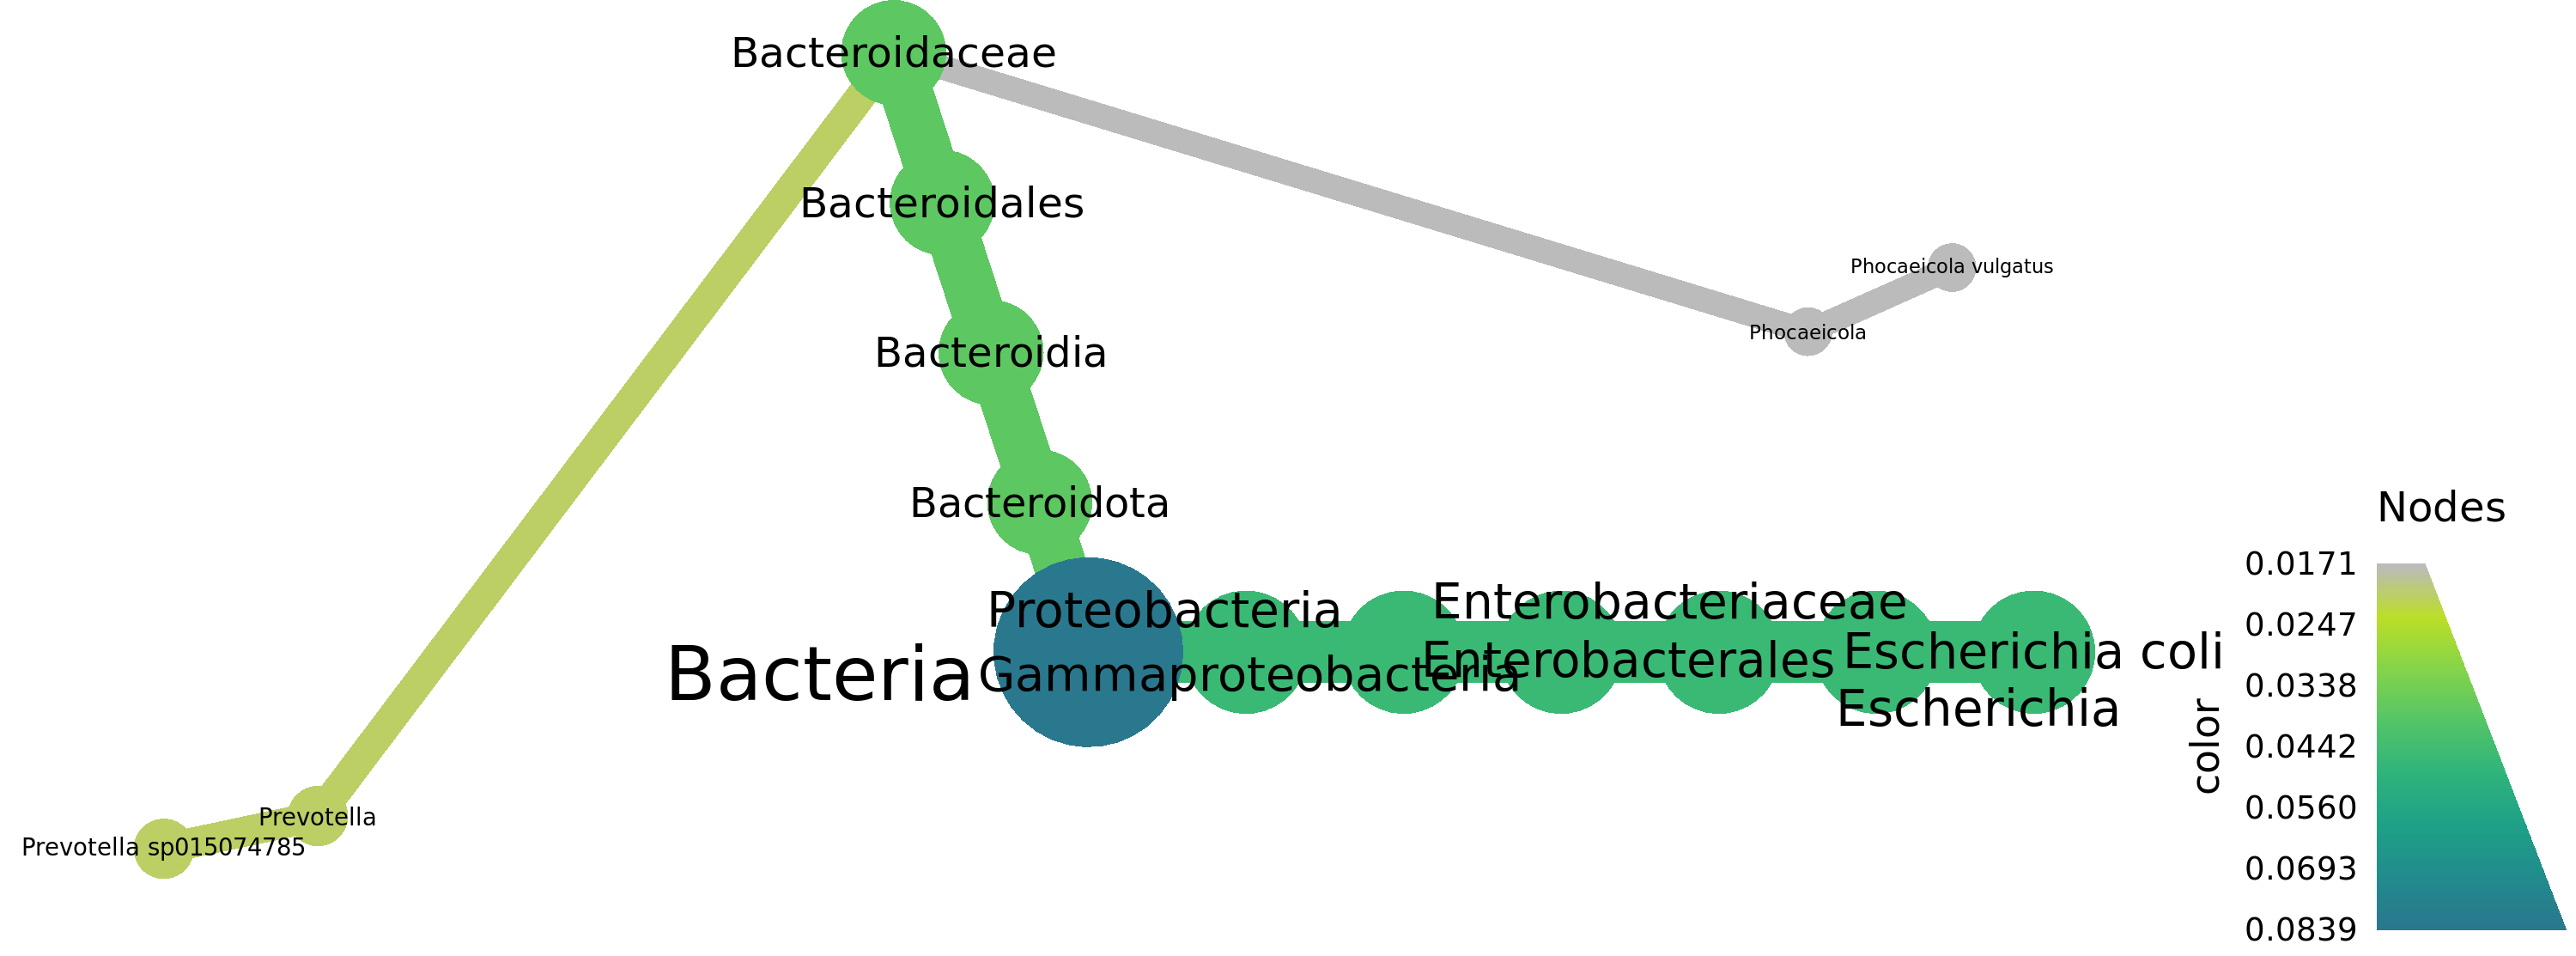

In [13]:
from IPython.display import Image
Image(filename='SRR5950647_1.tax.png') 

## Exercise for end of session today -

Try running the steps (from `sourmash gather` onwards) for the other sample, `SRR5935743_1`.